## Predictive Model

In [1]:
! pip install scikit-learn-intelex

import os 
import sys

# Get the absolute path of the project root 

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))

# Adding project root in syspath
sys.path.append(project_root)

import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)

warnings.filterwarnings("ignore")

from src.utils import reduce_mem_usage


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data Preparation

In [2]:
sales_df = pd.read_csv('../../data/raw/sales_train.csv')

# melting the data frame to obtain the unit sales for each day
df_train_sales = pd.melt(sales_df, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'd', value_name = 'sales_quantity')
del sales_df

# saving the data to interim
df_train_sales.to_csv('../../data/interim/melted_train_data.csv', index=False)
del df_train_sales

In [3]:
# loading the melted sales data and down casting the dtypes
df_train_sales = reduce_mem_usage(pd.read_csv('../../data/interim/melted_train_data.csv'))
# Loading the calendar data
df_calendar = pd.read_csv('../../data/raw/calendar.csv')
# Loading the weekly sales data
df_weekly_sales = pd.read_csv('../../data/raw/items_weekly_sell_prices.csv')

Memory usage of dataframe is 2867.74 MB
Memory usage after optimization is: 2598.89 MB
Decreased by 9.4%


In [4]:
df_train_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales_quantity
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [7]:
# taking only the store_id, item_id, d, and sales_quantity
df_train_sales = df_train_sales[['store_id','item_id','d', 'sales_quantity']]

# merging the calendar data and sales data
df_train_sales = df_train_sales.merge(df_calendar, how='left', on='d')
df_train_sales = df_train_sales.merge(df_weekly_sales, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])


# saving the final data
df_train_sales.to_csv('../../data/processed/final_train_data.csv', index=False)


del df_train_sales

In [8]:
# Loading the final data
df_train_sales = pd.read_csv('../../data/processed/final_train_data.csv')

In [9]:
df_train_sales.head()

,store_id,item_id,d,sales_quantity,date,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,d_1,0,2011-01-29,11101,NaN
1,CA_1,HOBBIES_1_002,d_1,0,2011-01-29,11101,NaN
2,CA_1,HOBBIES_1_003,d_1,0,2011-01-29,11101,NaN
3,CA_1,HOBBIES_1_004,d_1,0,2011-01-29,11101,NaN
4,CA_1,HOBBIES_1_005,d_1,0,2011-01-29,11101,NaN


In [10]:
# Replacing the NaN values in selling price with 0
df_train_sales['sell_price'].fillna(0, inplace=True)

<b>Calculating the total sales from the sales quantity and sell price</b>

In [11]:
# calculating the total_sales by multiplying the sales quantity and sell price
df_train_sales['total_sales'] = df_train_sales['sales_quantity']*df_train_sales['sell_price']

In [12]:
# dropping the wm_yr_wk, d, sales_quantity and sell price
df_train_sales.drop(columns=['wm_yr_wk', 'd','sales_quantity','sell_price'], inplace=True)

In [13]:
# Splitting the data
# Threshold to split test and train data set

split_date_threshold = '2014-01-11'

train_df = df_train_sales[df_train_sales['date']<split_date_threshold]

test_df = df_train_sales[df_train_sales['date']>=split_date_threshold]


del df_train_sales

## Data Understanding and Analysis

In [14]:
train_df.head()

,store_id,item_id,date,total_sales
0,CA_1,HOBBIES_1_001,2011-01-29,0.0
1,CA_1,HOBBIES_1_002,2011-01-29,0.0
2,CA_1,HOBBIES_1_003,2011-01-29,0.0
3,CA_1,HOBBIES_1_004,2011-01-29,0.0
4,CA_1,HOBBIES_1_005,2011-01-29,0.0


In [15]:
train_df_copy = train_df.copy()

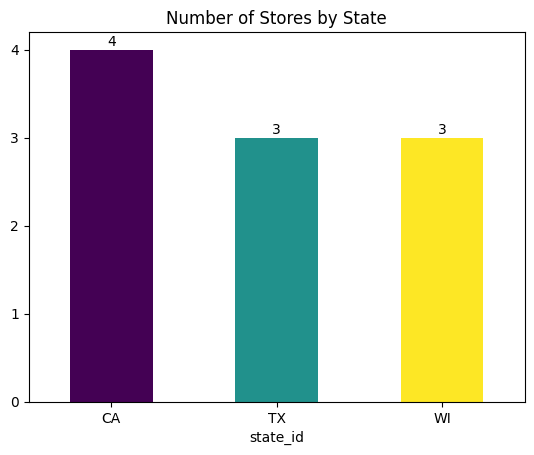

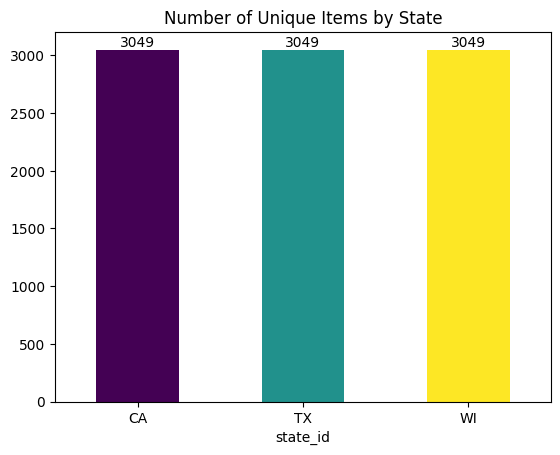

In [16]:
train_df_copy['state_id'] = train_df_copy['store_id'].apply(lambda x: x.split('_')[0])
train_df_copy['category'] = train_df_copy['item_id'].apply(lambda x: x.split('_')[0])


from src.visualization.plots import statewise_items_plot, statewise_stores_plot
statewise_stores_plot(train_df_copy)
statewise_items_plot(train_df_copy)

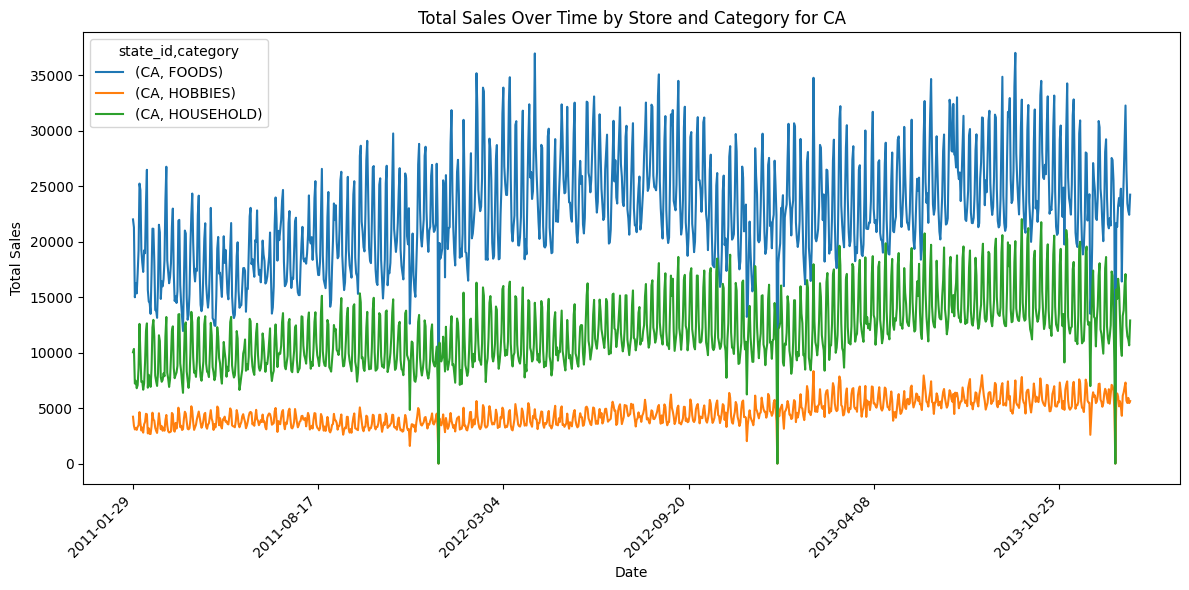

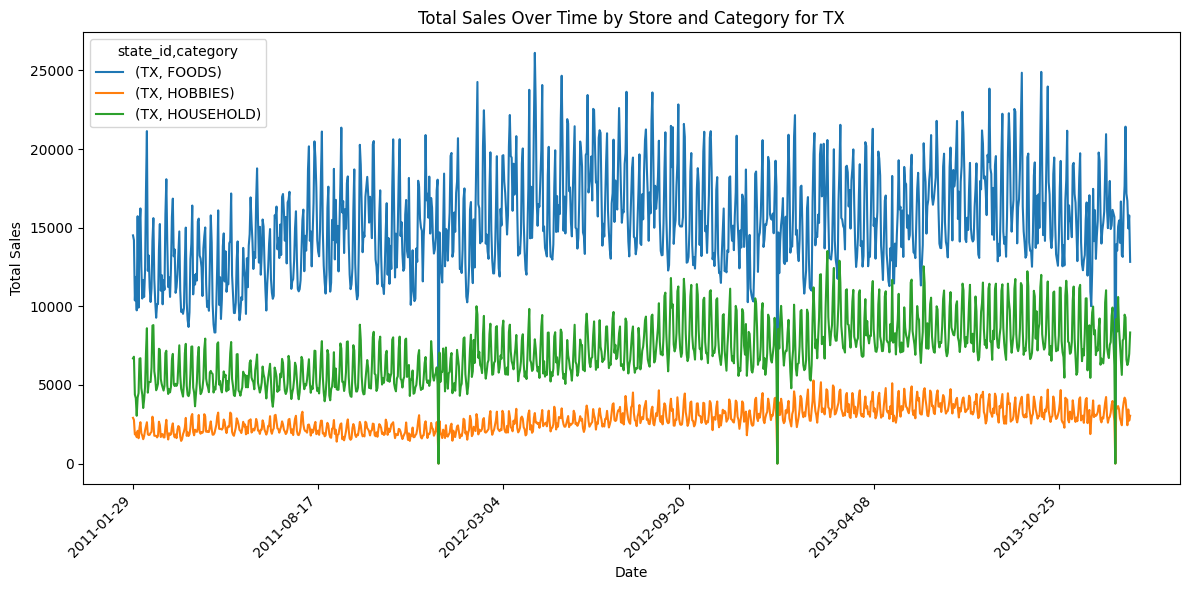

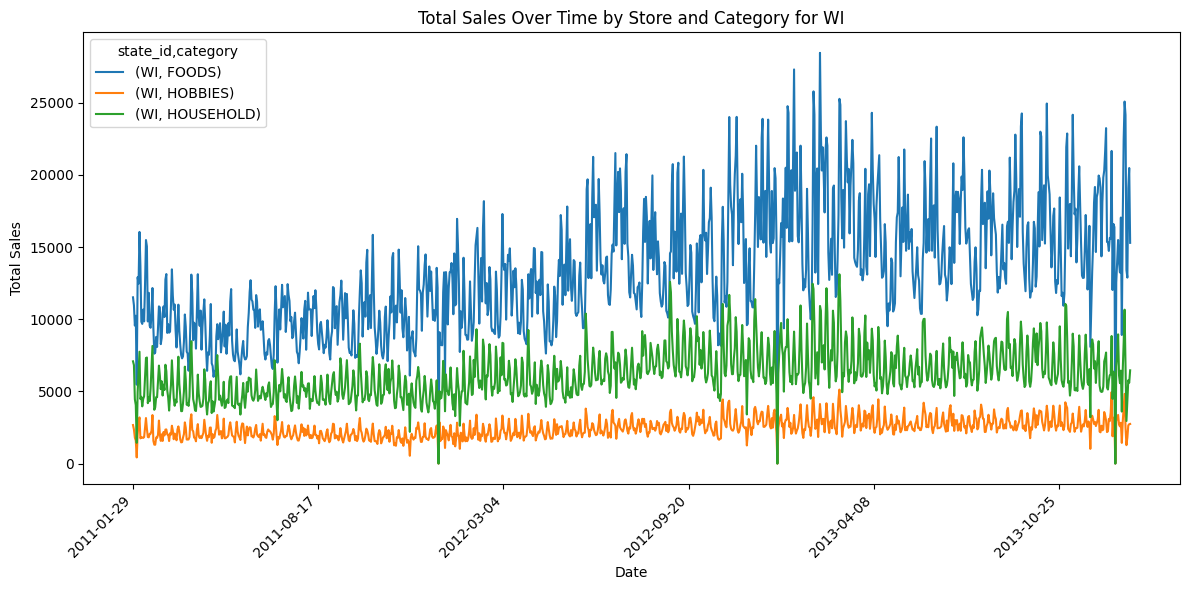

In [17]:
from src.visualization.plots import statewise_category_total_sales_plot
statewise_category_total_sales_plot(train_df_copy)

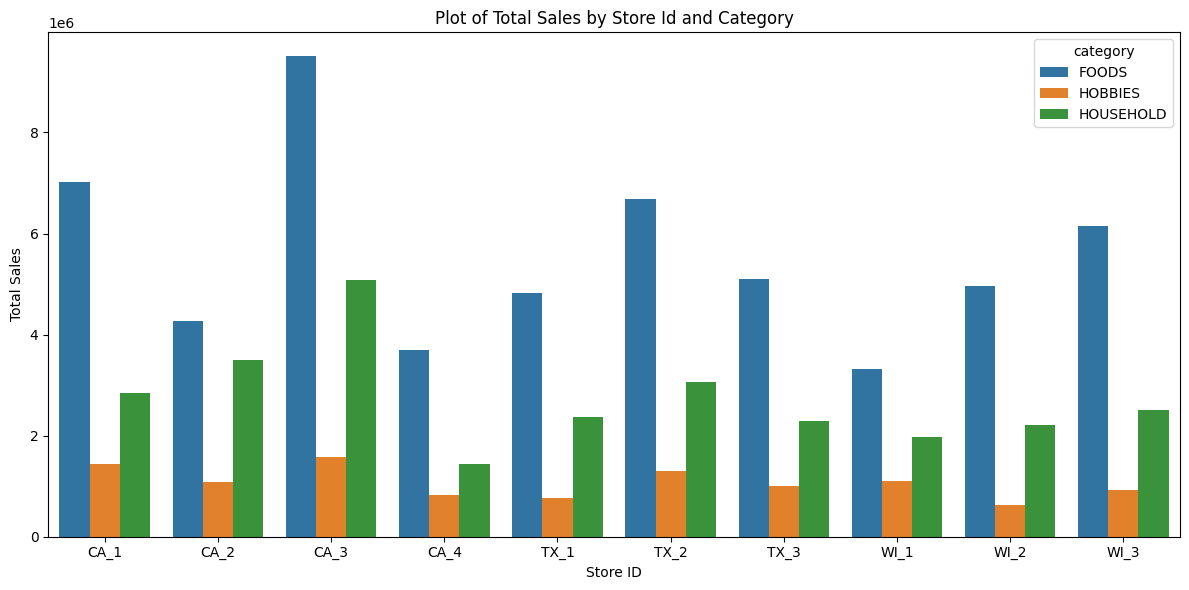

In [18]:
from src.visualization.plots import storeid_category_total_sales_plot

storeid_category_total_sales_plot(train_df_copy)

In [19]:
del train_df_copy

## Feature Extraction


-  Extract Features from Date
    - year, month, day, weekday
- Extract Features from store_id
    - State and store number
- Extract Features from item_id
    - Department, category, and item number

In [20]:
## Extracting features from date

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

train_df['year'] = train_df['date'].dt.year
test_df['year'] = test_df['date'].dt.year

train_df['month'] = train_df['date'].dt.month
test_df['month'] = test_df['date'].dt.month

train_df['day'] = train_df['date'].dt.day
test_df['day'] = test_df['date'].dt.day

train_df['weekday'] = train_df['date'].dt.weekday
test_df['weekday'] = test_df['date'].dt.weekday

In [21]:
# extracting feature from store_id=> state and store number
train_df['state']=train_df['store_id'].apply(lambda x: x.split('_')[0])
train_df['store_num']=train_df['store_id'].apply(lambda x: int(x.split('_')[1]))

test_df['state']=test_df['store_id'].apply(lambda x: x.split('_')[0])
test_df['store_num']=test_df['store_id'].apply(lambda x: int(x.split('_')[1]))

In [22]:
# extracting feature from item_id = > department, category and item number
train_df['department'] = train_df['item_id'].apply(lambda x: int(x.split('_')[1]))
train_df['category'] = train_df['item_id'].apply(lambda x: x.split('_')[0])
train_df['item'] = train_df['item_id'].apply(lambda x: int(x.split('_')[-1]))

test_df['department'] = test_df['item_id'].apply(lambda x: int(x.split('_')[1]))
test_df['category'] = test_df['item_id'].apply(lambda x: x.split('_')[0])
test_df['item'] = test_df['item_id'].apply(lambda x: int(x.split('_')[-1]))

In [23]:
train_df.drop(columns=['store_id', 'item_id', 'date'], inplace=True)
test_df.drop(columns=['store_id', 'item_id', 'date'], inplace=True)

In [24]:
train_df.to_csv('../../data/processed/train_final.csv', index=False)
test_df.to_csv('../../data/processed/test_final.csv', index=False)

del train_df
del test_df
# del df_train_sales

These processed train final and test final csv would be used for forecasting purpose too.

# Final Data Loading 

In [25]:
# This split of test and train data was performed and stored for reducing computaional resource usage

df_train = reduce_mem_usage(pd.read_csv('../../data/processed/train_final.csv')) # year before 2014-01-11
df_test = reduce_mem_usage(pd.read_csv('../../data/processed/test_final.csv')) # year 2014-01-11 and onwards



Memory usage of dataframe is 2507.65 MB
Memory usage after optimization is: 846.33 MB
Decreased by 66.2%
Memory usage of dataframe is 1077.03 MB
Memory usage after optimization is: 363.50 MB
Decreased by 66.2%


In [26]:
df_train.head()

,total_sales,year,month,day,weekday,state,store_num,department,category,item
0,0.0,2011,1,29,5,CA,1,1,HOBBIES,1
1,0.0,2011,1,29,5,CA,1,1,HOBBIES,2
2,0.0,2011,1,29,5,CA,1,1,HOBBIES,3
3,0.0,2011,1,29,5,CA,1,1,HOBBIES,4
4,0.0,2011,1,29,5,CA,1,1,HOBBIES,5


In [27]:
df_test.head()

,total_sales,year,month,day,weekday,state,store_num,department,category,item
0,0.000000,2014,1,11,5,CA,1,1,HOBBIES,1
1,0.000000,2014,1,11,5,CA,1,1,HOBBIES,2
2,0.000000,2014,1,11,5,CA,1,1,HOBBIES,3
3,23.203125,2014,1,11,5,CA,1,1,HOBBIES,4
4,0.000000,2014,1,11,5,CA,1,1,HOBBIES,5


In [26]:
# df_train_encoded = pd.get_dummies(df_train, columns=['state', 'category'], prefix=['state', 'category'])
# df_test_encoded = pd.get_dummies(df_test, columns=['state', 'category'], prefix=['state', 'category'])

## Data Encoding Pipeline

In [28]:
from src.features.datapipeline import CategoricalEncoder
from sklearn.pipeline import Pipeline

## pipeline that includes the custom categorical encoder
categorical_columns = ['state', 'category']

pipeline = Pipeline(steps=[
    ('categorical_encoder', CategoricalEncoder(categorical_columns=categorical_columns))
])

# Fit the pipeline on the training data
pipeline.fit(df_train)

# Transform the training and test data
df_train_encoded = pipeline.transform(df_train)
df_test_encoded = pipeline.transform(df_test)


In [29]:
import pickle 
# dumping pipeline for reuse
with open('..\..\models\predictive\pipeline_ohe.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [30]:
df_train_encoded.head()

,total_sales,year,month,day,weekday,store_num,department,item,state_CA,state_TX,state_WI,category_FOODS,category_HOBBIES,category_HOUSEHOLD
0,0.0,2011,1,29,5,1,1,1,True,False,False,False,True,False
1,0.0,2011,1,29,5,1,1,2,True,False,False,False,True,False
2,0.0,2011,1,29,5,1,1,3,True,False,False,False,True,False
3,0.0,2011,1,29,5,1,1,4,True,False,False,False,True,False
4,0.0,2011,1,29,5,1,1,5,True,False,False,False,True,False


In [31]:
X_train = df_train_encoded.drop(columns='total_sales', axis=1)
y_train = df_train_encoded['total_sales']


X_test = df_test_encoded.drop(columns='total_sales', axis=1)
y_test = df_test_encoded['total_sales']

In [32]:

X_train.head()

,year,month,day,weekday,store_num,department,item,state_CA,state_TX,state_WI,category_FOODS,category_HOBBIES,category_HOUSEHOLD
0,2011,1,29,5,1,1,1,True,False,False,False,True,False
1,2011,1,29,5,1,1,2,True,False,False,False,True,False
2,2011,1,29,5,1,1,3,True,False,False,False,True,False
3,2011,1,29,5,1,1,4,True,False,False,False,True,False
4,2011,1,29,5,1,1,5,True,False,False,False,True,False


In [33]:
X_test.head()

,year,month,day,weekday,store_num,department,item,state_CA,state_TX,state_WI,category_FOODS,category_HOBBIES,category_HOUSEHOLD
0,2014,1,11,5,1,1,1,True,False,False,False,True,False
1,2014,1,11,5,1,1,2,True,False,False,False,True,False
2,2014,1,11,5,1,1,3,True,False,False,False,True,False
3,2014,1,11,5,1,1,4,True,False,False,False,True,False
4,2014,1,11,5,1,1,5,True,False,False,False,True,False


# Modeling Phase

## Baseline model development
## Logistic Regression 


In [34]:

from sklearn.linear_model import LinearRegression
from src.models.evaluation_metric import print_regressor_scores, plot_predicted_vs_actual
from src.models.model import BaseLineRegressor

 

In [35]:
lin_reg = BaseLineRegressor(LinearRegression())

lin_reg.fit(X_train, y_train)

In [36]:
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)


In [37]:

print_regressor_scores(y_train, y_train_pred, 'train set')
print("------"*10)
print_regressor_scores(y_test, y_test_pred, 'test set')

RMSE train set: 8.91016295749426
MAE train set : 4.129433703059442
R2 score train set : 0.013090599444153805
------------------------------------------------------------
RMSE test set: 9.555755269876174
MAE test set : 4.7753218795647525
R2 score test set : 0.010958195913210456


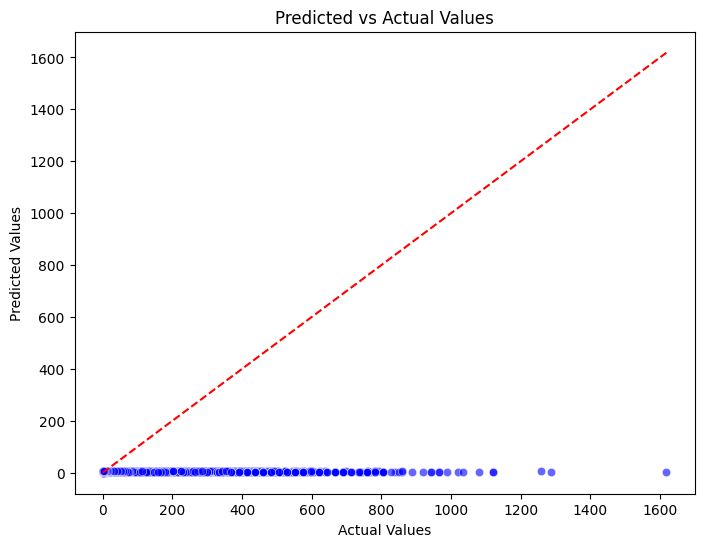

In [38]:
plot_predicted_vs_actual(y_test, y_test_pred)

# 2) LightGBM 

In [39]:
import lightgbm as lgb

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 15,  # Lower values to reduce complexity
    'learning_rate': 0.1,
    'feature_fraction': 0.8,  # Use a subset of features
    'bagging_fraction': 0.8,   # Use a subset of data
    'bagging_freq': 5,
    'max_depth': 100,          
    'min_data_in_leaf': 2,    # Prevent overfitting
    'verbose': -1
}




In [40]:
from lightgbm import LGBMRegressor

# Initialize the model with default parameters
model = LGBMRegressor(**params, random_state=42)

# Train the model
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
              max_depth=100, metric='rmse', min_data_in_leaf=2, num_leaves=15,
              objective='regression', random_state=42, verbose=-1)

In [41]:
y_train_pred = model.predict(X_train, num_iteration=model.best_iteration_)

y_test_pred = model.predict(X_test, num_iteration=model.best_iteration_)


In [42]:
print_regressor_scores(y_train, y_train_pred, 'train set')
print("------"*10)
print_regressor_scores(y_test, y_test_pred, 'test set')

RMSE train set: 8.589651244763065
MAE train set : 3.978706315685244
R2 score train set : 0.08281476648059871
------------------------------------------------------------
RMSE test set: 9.288027202974206
MAE test set : 4.314933324477052
R2 score test set : 0.0656027134235102


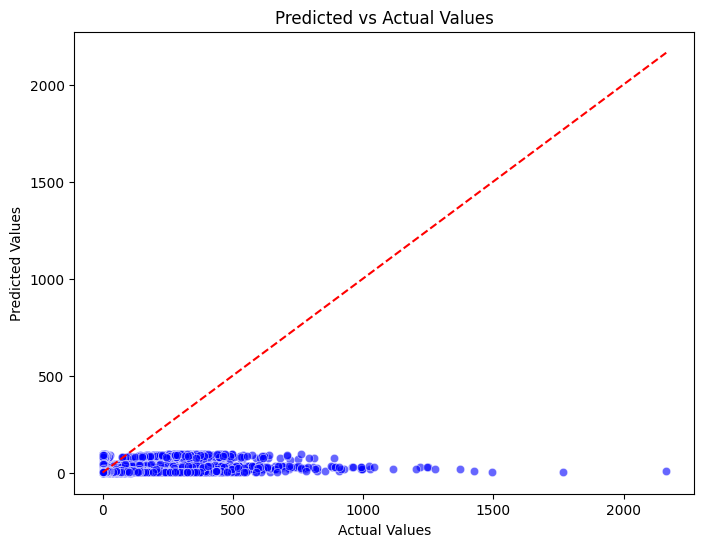

In [43]:
plot_predicted_vs_actual(y_train, y_train_pred)

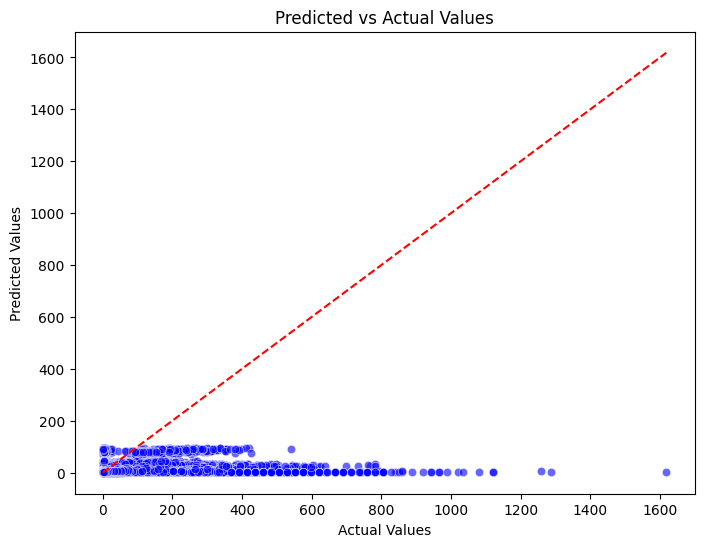

In [44]:
plot_predicted_vs_actual(y_test, y_test_pred)

## 3) Decision Tree Model

In [45]:
from sklearn.model_selection import train_test_split

# df_train_encoded = pd.get_dummies(df_train, columns=['state', 'category'], prefix=['state', 'category'])
# df_test_encoded = pd.get_dummies(df_test, columns=['state', 'category'], prefix=['state', 'category'])

X = df_train_encoded.drop(columns=['total_sales'])
y = df_train_encoded['total_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2)

In [46]:
from sklearn.tree import DecisionTreeRegressor

# overfitting the data for analysis
# Initialize the Decision Tree model with default parameters
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [47]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


In [48]:

from src.models.evaluation_metric import print_regressor_scores
print_regressor_scores(y_train, y_train_pred, 'train set')
print("------"*10)
print_regressor_scores(y_test, y_test_pred, 'test set')


RMSE train set: 0.0
MAE train set : 0.0
R2 score train set : 1.0
------------------------------------------------------------
RMSE test set: 7.340937122592215
MAE test set : 2.7373736854167405
R2 score test set : 0.33713856551056465


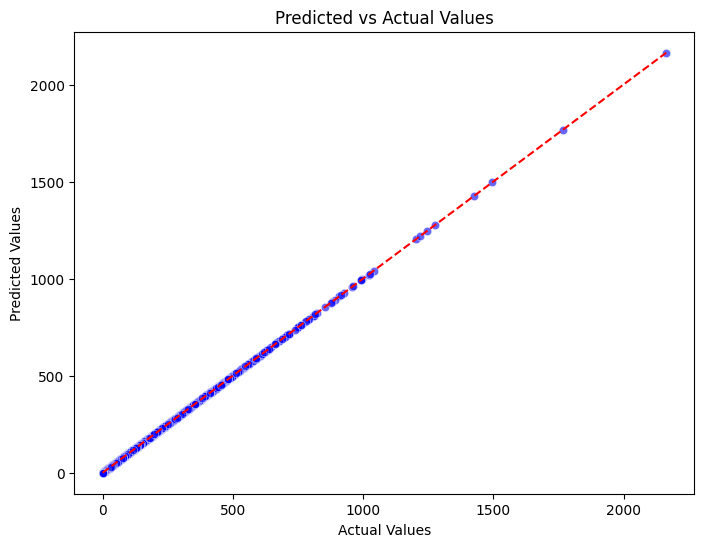

In [49]:
from src.models.evaluation_metric import plot_predicted_vs_actual

plot_predicted_vs_actual(y_train, y_train_pred)

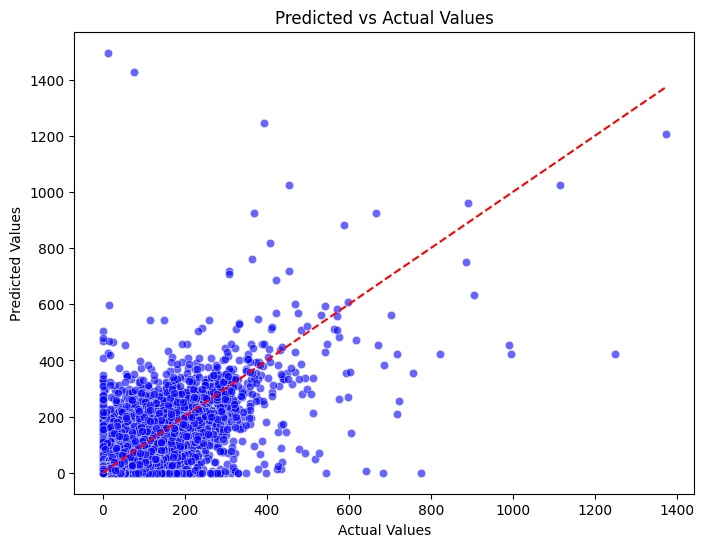

In [50]:

plot_predicted_vs_actual(y_test, y_test_pred)

# 3.1) Tuning the Hyperparameters

### 3.a) Using High Computing Resource
The hyperparameter of Decision Tree is tuned using the ihpc resource from UTS.
The system had 16 cores and 126GB RAM. Thus utilizing the resource, the preferred hyperparameters to tune were

``` python
params =  {
    'max_depth': range(15,100),
    'min_samples_split': range(3, 70),
    'min_samples_leaf': [1, 2, 4, 6],
    # 'max_features': [None, 'sqrt', 'log2'],
  }
```

These hyperparameters were tuned using RandomSearchCV with 5-fold cross validation.


### Full code 

```python

from src.evaluation_metric import print_regressor_scores, plot_predicted_vs_actual
params = {
    'max_depth': range(15,100),
    'min_samples_split': range(3, 70),
    'min_samples_leaf': [1, 2, 4, 6],
    # 'max_features': [None, 'sqrt', 'log2'],
}


from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score
dt_regressor = DecisionTreeRegressor(max_depth=15, random_state=42)

random_search = RandomizedSearchCV(
    dt_regressor, 
    param_distributions=params,
    n_iter=100, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all processors
    cv=5,  # 5-fold cross-validation
    verbose=1, 
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters: {random_search.best_params_}")

# Get the best score
print(f"Best R^2 score: {random_search.best_score_}")

# Evaluate on the test set
y_pred = random_search.best_estimator_.predict(X_test)
print_regressor_scores(y_test, y_pred, "Test")


# File to save the best parameters and results
output_file = "./best_params.txt"

# Get the best parameters
best_params = random_search.best_params_
best_score = random_search.best_score_

# Evaluate on the test set
y_pred = random_search.best_estimator_.predict(X_test)
test_score = print_regressor_scores(y_test, y_pred, "Test")
 
# Save to a file
with open(output_file, "w") as f:
    f.write(f"Best Parameters: {best_params}\n")
    f.write(f"Best R^2 Score (Cross-Validation): {best_score:.4f}\n")
    f.write(f"Test Set Evaluation: {test_score}\n")

```

The hyperparameter tuning is resource intensive task thus these codes were run on ihpc, rather than in local system. The best parameter obtained was:
```python
best_params:  {'min_samples_split': 42, 'min_samples_leaf': 6, 'max_depth': 41}
```

### 3.b) Performance-wise Final Model using Decision Tree Best Params 

In [51]:
final_model = DecisionTreeRegressor(max_depth=41,
    min_samples_split=42,
    min_samples_leaf=6, 
)

final_model.fit(X_train,y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)


print_regressor_scores(y_train, y_train_pred, 'train set')
print("------"*10)
print_regressor_scores(y_test, y_test_pred, 'test set')

RMSE train set: 5.034337673302683
MAE train set : 2.0067810535826873
R2 score train set : 0.684103473968053
------------------------------------------------------------
RMSE test set: 5.6144479694507
MAE test set : 2.266403856312062
R2 score test set : 0.6122660166716077


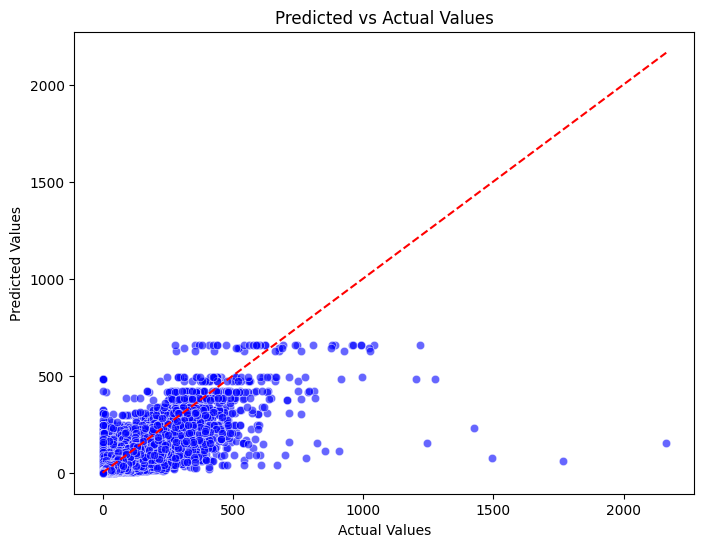

In [52]:
plot_predicted_vs_actual(y_train, y_train_pred)

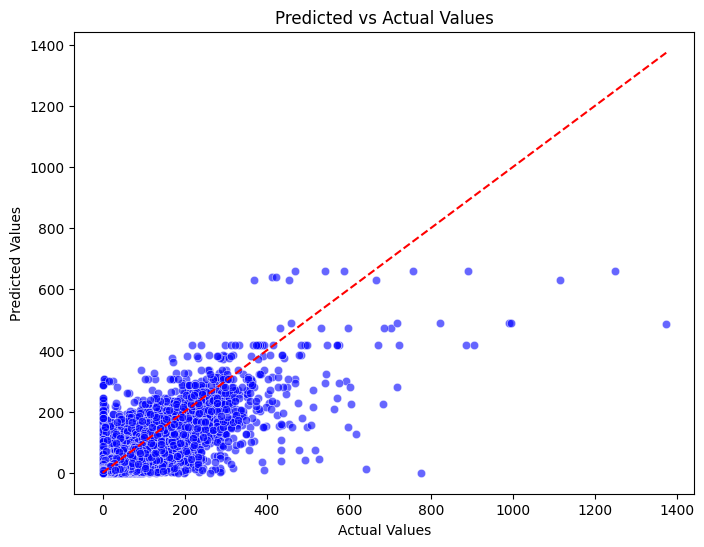

In [53]:
plot_predicted_vs_actual(y_test, y_test_pred)

# Saving model

In [54]:
import pickle
# Save the model using pickle
with open("../../models/predictive/final_decision_tree_final_tuned.pkl", 'wb') as file:
    pickle.dump(model, file)

Since the pickle file is too large, and compressing it didn't help, loading it failed due to the limited 512MB RAM available in Render. Therefore, training an XGBoostRegressor to create a smaller model is a viable alternative for deployment.

# 4) Deployable Final model XGBRegressor

The XGBRegressor model was hyperparameter were tuned using hyperopt

``` python
rstate = np.random.default_rng(42)

space = {
    'max_depth': hp.choice('max_depth', range(3, 15, 1)),
    'min_child_weight': hp.choice('min_child_weight', range(3, 15, 1)),
    'gamma': hp.quniform('gamma', 0, 0.5, 0.05)
}


def objective(space):
    xgboost_reg = XGBRegressor(
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        gamma=space['gamma'],
        objective='reg:squarederror'
    )

    # Cross-validation to evaluate model performance
    # Evaluate the model using cross-validation
    scores = cross_val_score(xgboost_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse = np.sqrt(-scores.mean())

    # The objective is to minimize RMSE
    return {'loss': rmse, 'status': STATUS_OK}

# Run the optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,  
            trials=trials)

print("Best hyperparameters:", best)

```

In [55]:
from xgboost import XGBRegressor
params = {'gamma': 0.5, 'max_depth': 13, 'min_child_weight': 9}
# params = {'gamma': 0.30000000000000004, 'max_depth': 8, 'min_child_weight': 9}
xgb_regressor = XGBRegressor(**params, random_state=42)
xgb_regressor.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [56]:
y_train_pred = xgb_regressor.predict(X_train)
y_test_pred = xgb_regressor.predict(X_test)

In [57]:
from src.models.evaluation_metric import print_regressor_scores
print_regressor_scores(y_train, y_train_pred, 'train set')
print("------"*10)
print_regressor_scores(y_test, y_test_pred, 'test set')


RMSE train set: 7.546977519989014
MAE train set : 3.4110212326049805
R2 score train set : 0.2900851368904114
------------------------------------------------------------
RMSE test set: 7.83778715133667
MAE test set : 3.493110179901123
R2 score test set : 0.24437397718429565


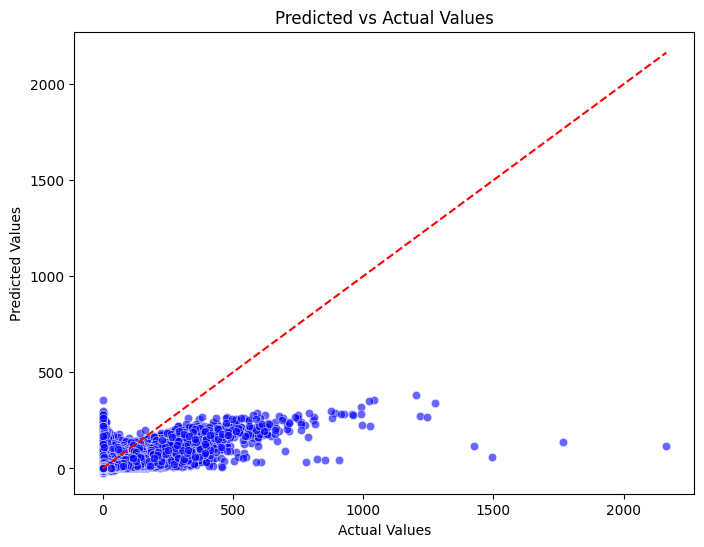

In [58]:
from src.models.evaluation_metric import plot_predicted_vs_actual

plot_predicted_vs_actual(y_train, y_train_pred)

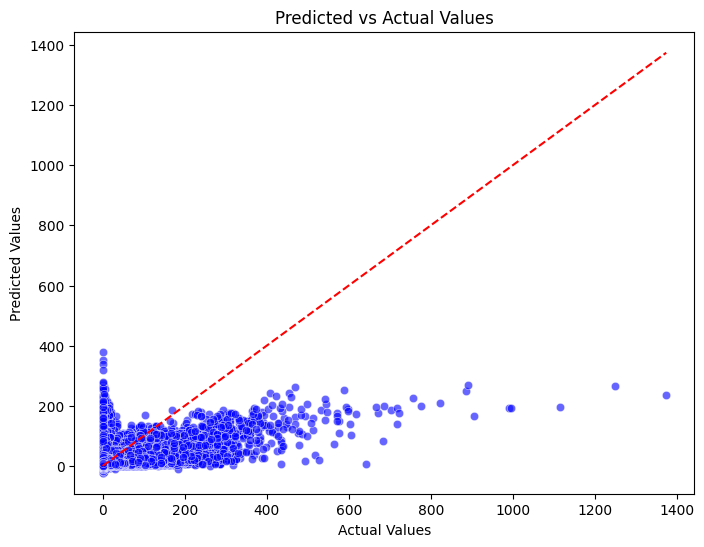

In [59]:
plot_predicted_vs_actual(y_test, y_test_pred)

# Saving model

In [60]:
import pickle
# Save the model using pickle
with open("../../models/predictive/xgb_tuned.pkl", 'wb') as file:
    pickle.dump(xgb_regressor, file)